# Calculates colocalization between markers in selected cells

In [1]:
import os
import glob
from pathlib import Path 
import sys
import fnmatch
from itertools import cycle
from functools import partial
from math import log10, sqrt, ceil, floor, log, exp, pi, isnan
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=30)
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmapy
import tifffile
import pandas as pd
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
from tqdm.notebook import tqdm, trange
from skimage import color
from skimage.transform import rescale
from skimage.util import view_as_windows
from statannot import add_stat_annotation
import scipy
import pickle
import time

import multiprocessing as mp
from multiprocessing import Process, Queue, Value, Array, Pool

import matplotlib.font_manager as fm
%matplotlib inline
%gui qt5

In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from my_io import display_list_image, read_tiff_files
from config import *

In [4]:
# Figures location
save_path = f"{data_figure}/colocalization/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Load the datasets

In [5]:
pickle_name_temp = f"{data_path_masked_BM}/image_list_BM.pickle"
zoomed_image_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/image_list_UC.pickle"
zoomed_image_list_UC = pickle.load(open(pickle_name_temp, "rb"))

In [6]:
pickle_name_temp = f"{data_path_masked_BM}/mask_list_BM.pickle"
zoomed_mask_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/mask_list_UC.pickle"
zoomed_mask_UC = pickle.load(open(pickle_name_temp, "rb"))

### Calculate area of cells

In [7]:
list_area_ph_BM = []
list_area_ph_UC = []

for cell in range(len(zoomed_image_list_BM)):       
    mask_temp = zoomed_mask_BM[cell].copy()/255
    area_temp = mask_temp.sum()
    list_area_ph_BM.append(area_temp)

for cell in range(len(zoomed_image_list_UC)):       
    mask_temp = zoomed_mask_UC[cell].copy()/255
    area_temp = mask_temp.sum()
    list_area_ph_UC.append(area_temp)

In [8]:
window_size_contact = 5
pad_size_contact = window_size_contact//2

In [9]:
def marker_list_2_pair(marker_1_list, marker_2_list, dict_marker_organelle=dict_marker_organelle):
    list_pair = []

    for m1, m2 in zip(marker_1_list, marker_2_list):
        list_pair.append(f"{m1}_{m2}")
        
    return(list_pair)

### Colocalization analysis

In [10]:
df_coloc_all_BM = pd.DataFrame()
cell_abs_count = 1
cell_type_label = []
for m in BM_indices:
    image_array_temp = zoomed_image_list_BM[m].copy()
    for c_1_count, c_1 in enumerate(idx_channel_names_modif):
        image_array_temp_1 = image_array_temp[c_1].copy()
        image_array_temp_1 = (image_array_temp_1 >= np.quantile(image_array_temp_1, 0.9)).astype(np.int8)
        for c_2_count, c_2 in enumerate(idx_channel_names_modif):
            
            image_array_temp_2 = image_array_temp[c_2].copy()
            image_array_temp_2 = (image_array_temp_2 >= np.quantile(image_array_temp_2, 0.9)).astype(np.int8)
            image_array_temp_all = (image_array_temp_2 * image_array_temp_1)
            coloc = image_array_temp_all.sum()/list_area_ph_BM[m]
            list_pair = marker_list_2_pair([channel_names[c_1]], [channel_names[c_2]])
            dict_temp = {
                'Coloc': [coloc],
                'Cell': [m],
                'Marker1':[channel_names[c_1]],
                'Marker2':[channel_names[c_2]],
                'Cell Type':['BM'],
                'Area':[list_area_ph_BM[m]],
                'Cell number':[cell_abs_count],
                'Marker pair':list_pair
                        }
            df_image_temp = pd.DataFrame(dict_temp)
            df_coloc_all_BM = pd.concat([df_coloc_all_BM, df_image_temp])
    cell_abs_count += 1
    cell_type_label.append('BM')

In [11]:
df_coloc_all_UC = pd.DataFrame()

for m in UC_indices:
    image_array_temp = zoomed_image_list_UC[m].copy()
    for c_1_count, c_1 in enumerate(idx_channel_names_modif):
        image_array_temp_1 = image_array_temp[c_1].copy()
        image_array_temp_1 = (image_array_temp_1 >= np.quantile(image_array_temp_1, 0.9)).astype(np.int8)
        for c_2_count, c_2 in enumerate(idx_channel_names_modif):
            
            image_array_temp_2 = image_array_temp[c_2].copy()
            image_array_temp_2 = (image_array_temp_2 >= np.quantile(image_array_temp_2, 0.9)).astype(np.int8)
            image_array_temp_all = (image_array_temp_2 * image_array_temp_1)
            coloc = image_array_temp_all.sum()/list_area_ph_UC[m]
            list_pair = marker_list_2_pair([channel_names[c_1]], [channel_names[c_2]])
            dict_temp = {
                'Coloc': [coloc],
                'Cell': [m],
                'Marker1':[channel_names[c_1]],
                'Marker2':[channel_names[c_2]],
                'Cell Type':['UC'],
                'Area':[list_area_ph_UC[m]],
                'Cell number':[cell_abs_count],
                'Marker pair':list_pair
                        }
            df_image_temp = pd.DataFrame(dict_temp)
            df_coloc_all_UC = pd.concat([df_coloc_all_UC, df_image_temp])
    cell_abs_count += 1
    cell_type_label.append('UC')

In [12]:
coloc_matrix_BM = np.zeros((len(BM_indices), len(channel_names_modif), len(channel_names_modif)), dtype=np.float64)

for m in range(len(BM_indices)):
    for c_1_count, c_1 in enumerate(channel_names_modif):
        for c_2_count, c_2 in enumerate(channel_names_modif):
            coloc_matrix_BM[m, c_2_count, c_1_count] = df_coloc_all_BM.loc[(df_coloc_all_BM['Cell number']-1 == m) & (df_coloc_all_BM['Marker1'] == c_1) & (df_coloc_all_BM['Marker2'] == c_2)]['Coloc'].values[0]

In [13]:
coloc_matrix_UC = np.zeros((len(UC_indices), len(channel_names_modif), len(channel_names_modif)), dtype=np.float64)

for m in range(len(UC_indices)):
    for c_1_count, c_1 in enumerate(channel_names_modif):
        for c_2_count, c_2 in enumerate(channel_names_modif):
            coloc_matrix_UC[m, c_2_count, c_1_count] = df_coloc_all_UC.loc[(df_coloc_all_UC['Cell number']-8 == m) & (df_coloc_all_UC['Marker1'] == c_1) & (df_coloc_all_UC['Marker2'] == c_2)]['Coloc'].values[0]

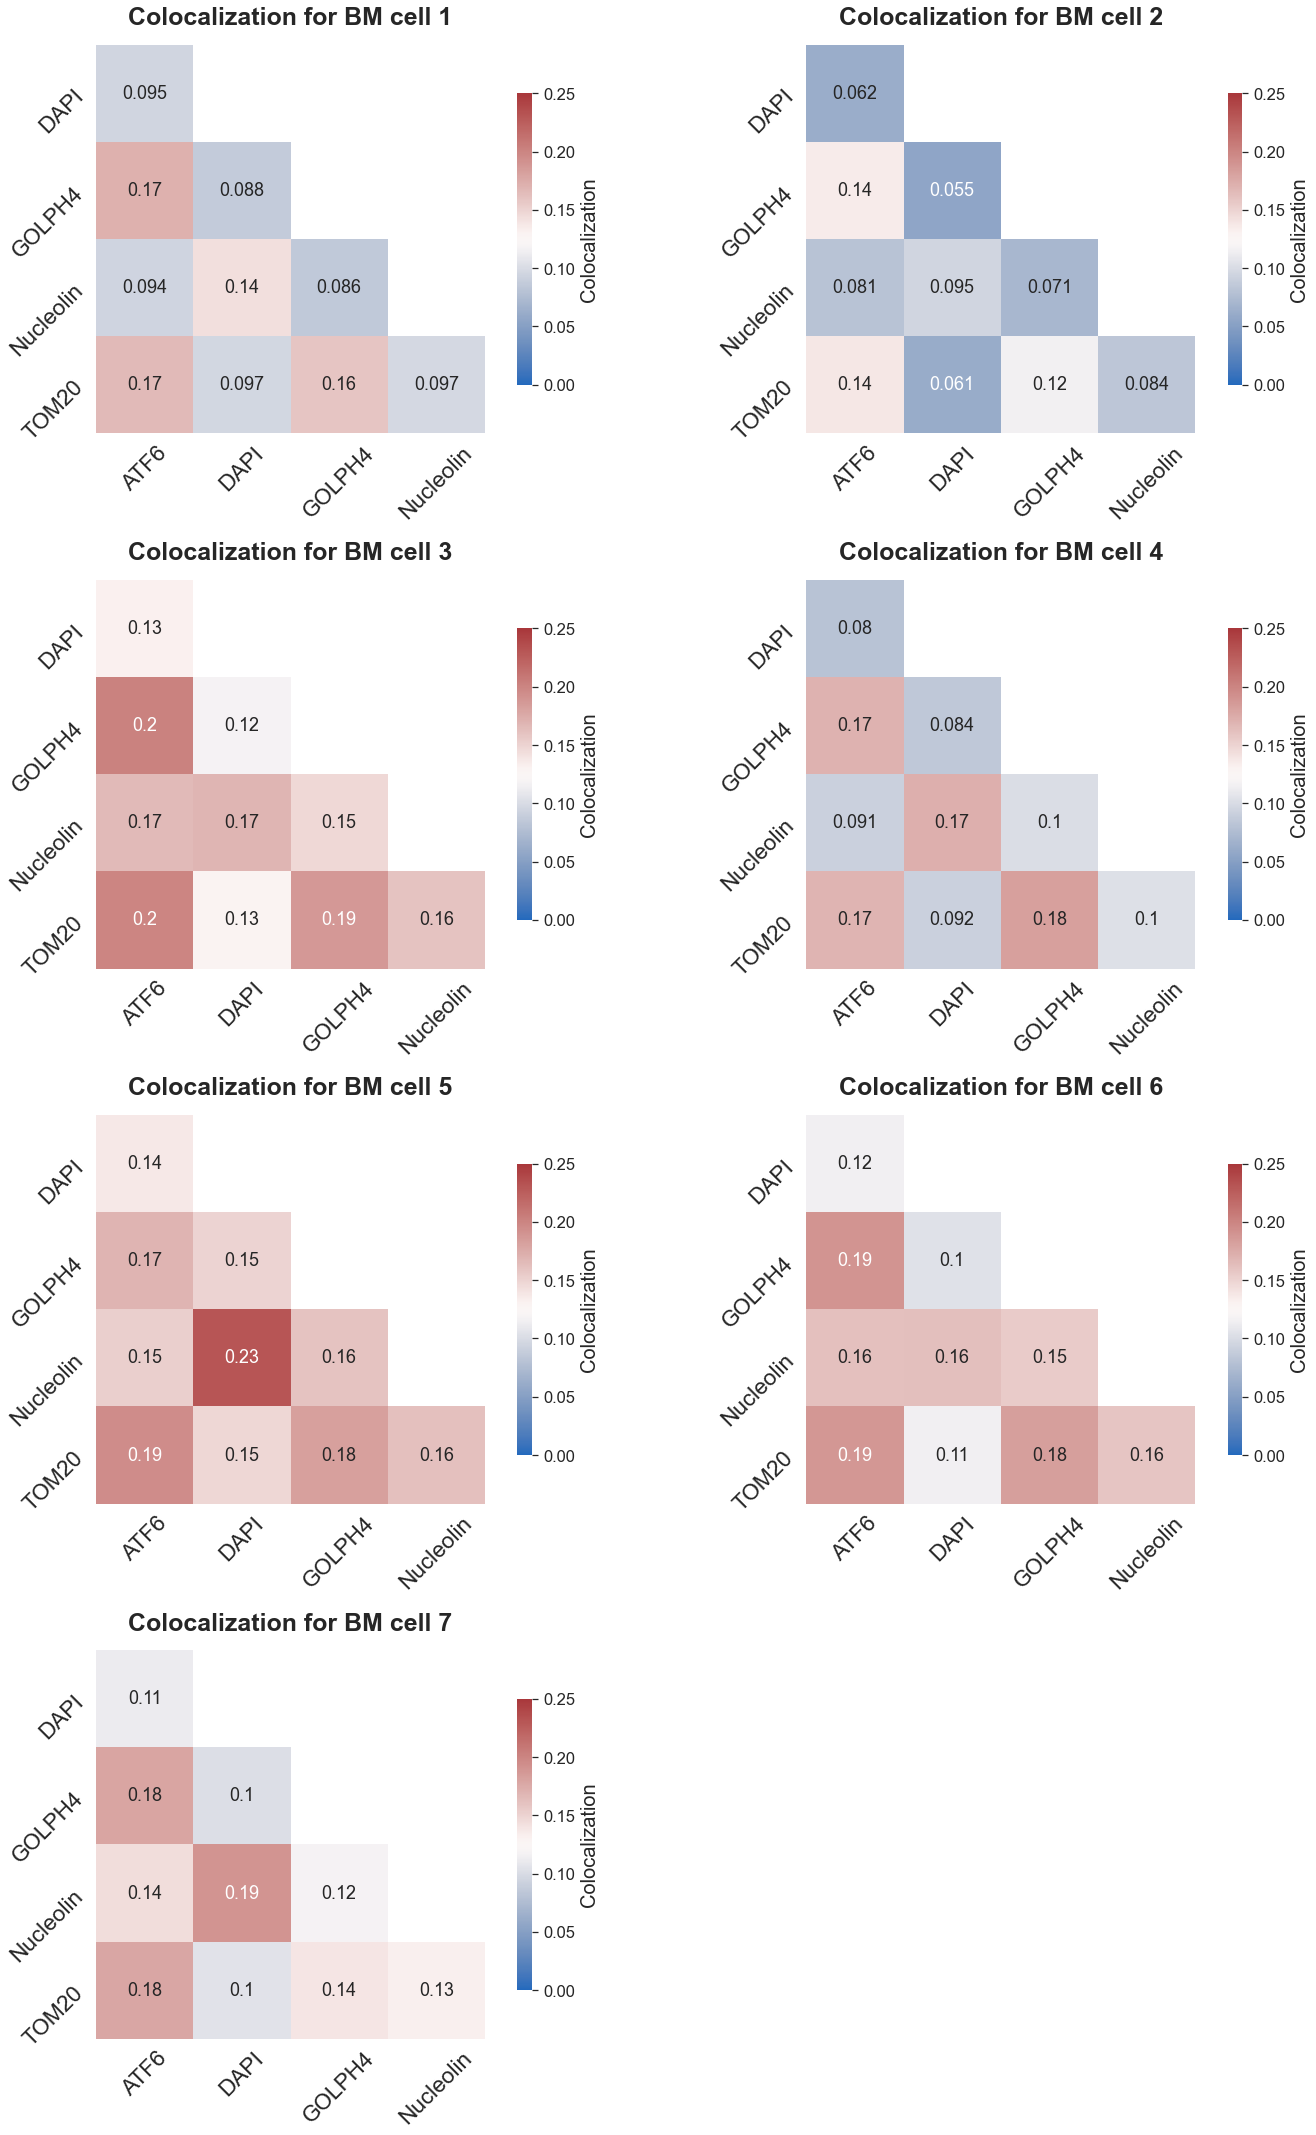

In [14]:
mask = np.zeros_like(coloc_matrix_BM[0])
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
plt.style.use('seaborn-paper')

fig, axes = plt.subplots(4, 2, figsize=(20, 30))
sns.set(font_scale=1.5)
for i, ax in zip(range(len(BM_indices)), axes.flatten()):
    
    df_coloc = pd.DataFrame(coloc_matrix_BM[i][1:,0:-1], columns=channel_names_modif[0:-1], index=channel_names_modif[1:])
    g = sns.heatmap(df_coloc, square=True, ax=ax, annot=True, cmap="vlag", mask=mask[1:,0:-1], cbar_kws={"shrink": 0.75, 'label': 'Colocalization'}, vmin=0, vmax=0.25)
    g.figure.axes[-1].yaxis.label.set_size(20)
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22.5, rotation=45)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22.5, rotation=45)
    ax.set_title(f"Colocalization for BM cell {i+1}",fontsize= 25, pad=20, fontweight ="bold")
axes[3,1].set_visible(False)

plt.tight_layout()
image_path_png = save_path + "/coloc_BM.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

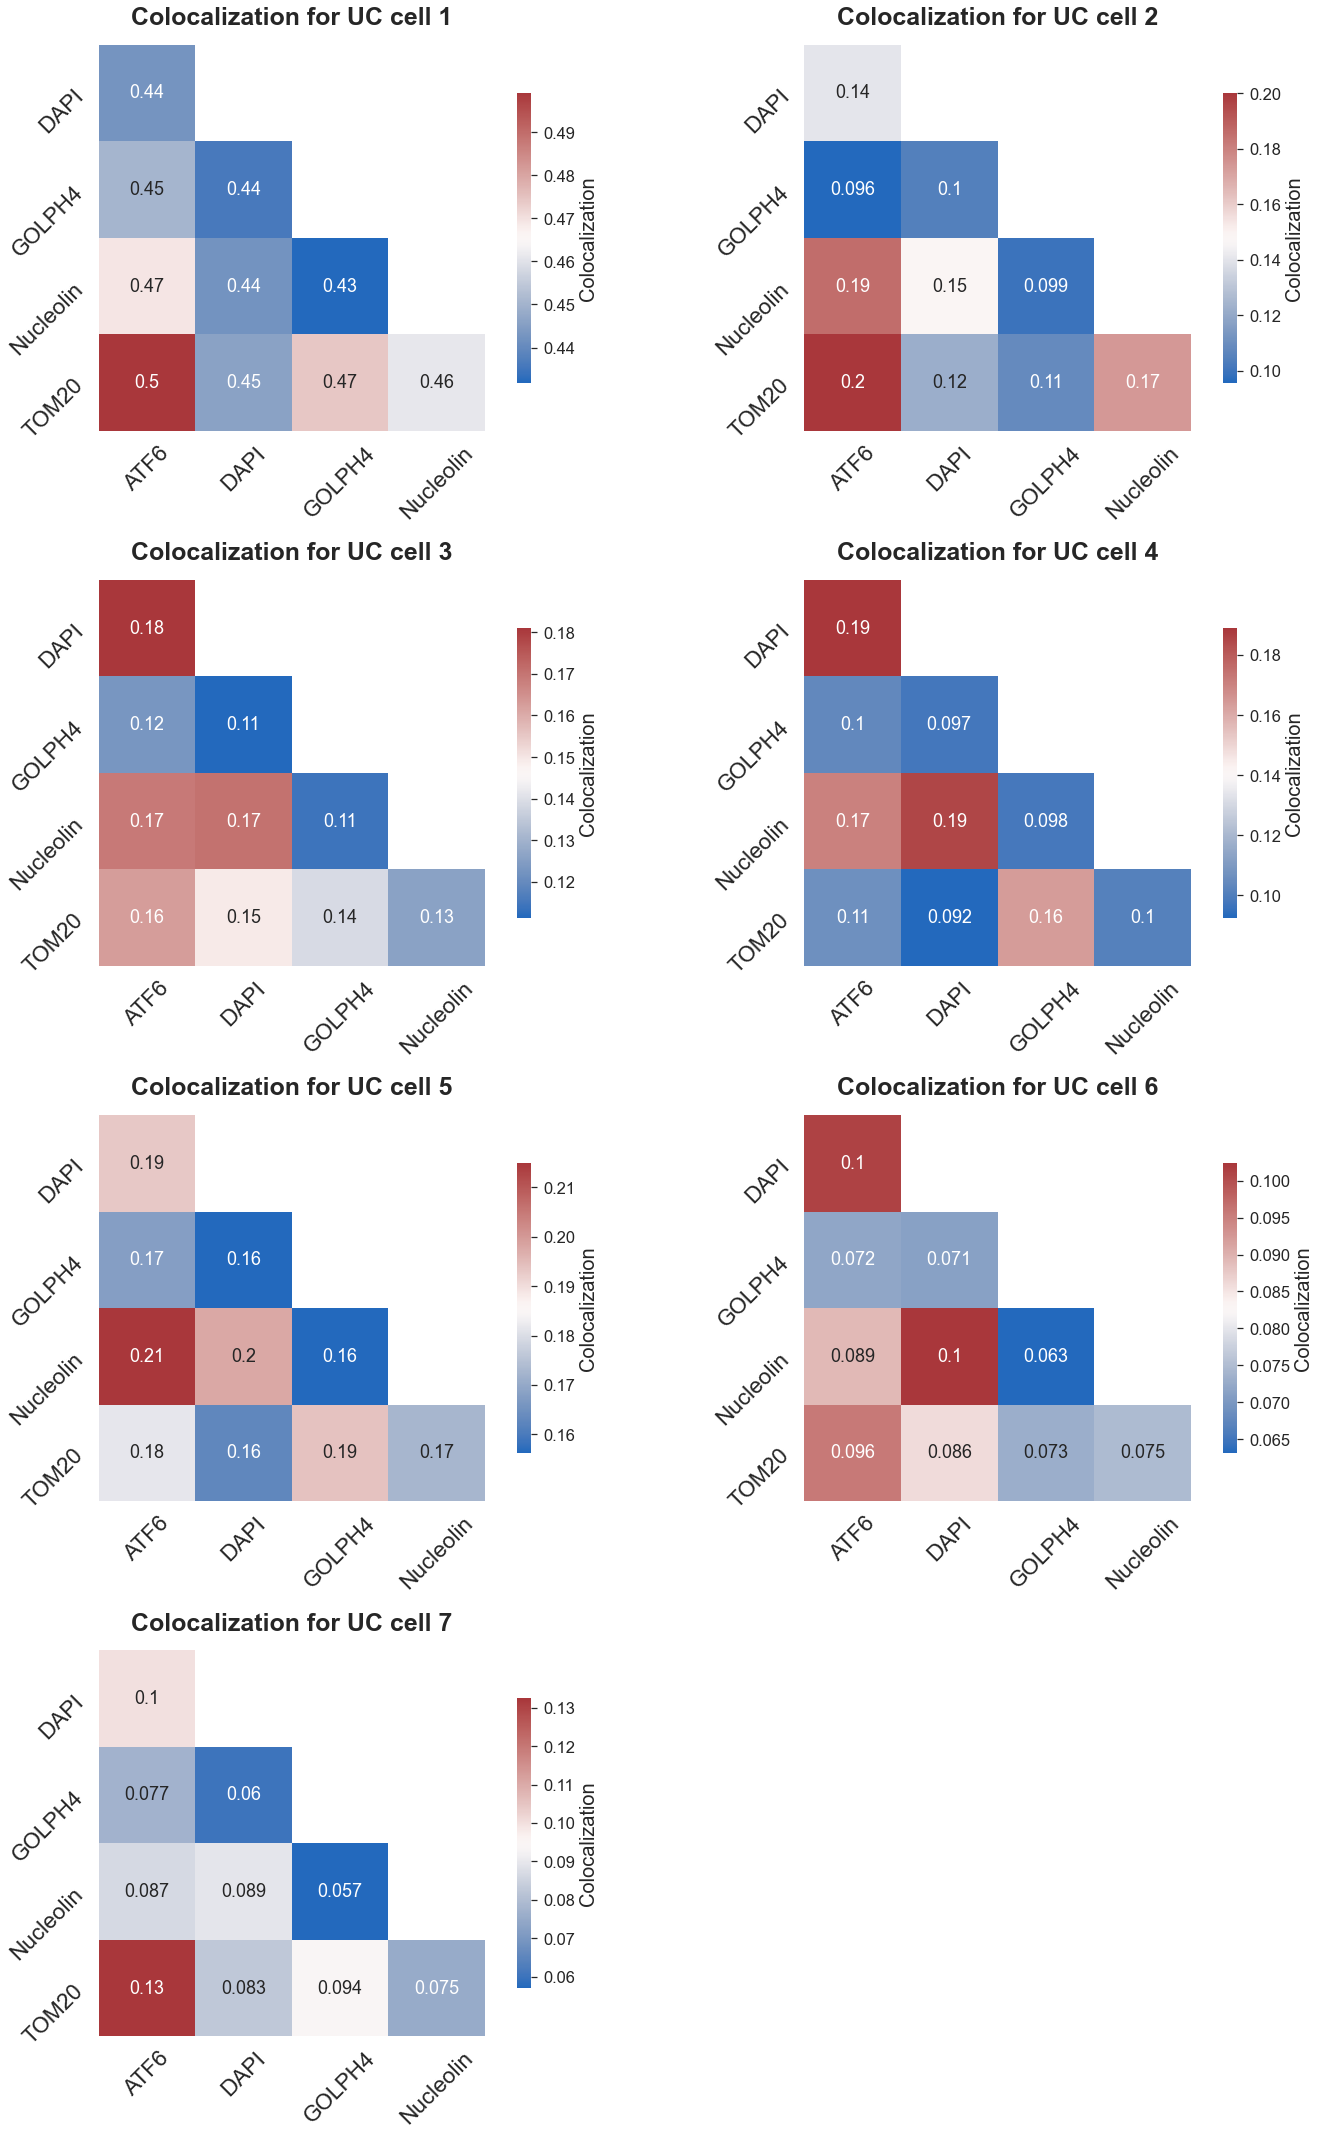

In [15]:
mask = np.zeros_like(coloc_matrix_UC[0])
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
plt.style.use('seaborn-paper')

fig, axes = plt.subplots(4, 2, figsize=(20, 30))
sns.set(font_scale=1.5)
for i, ax in zip(range(len(UC_indices)), axes.flatten()):
    df_coloc = pd.DataFrame(coloc_matrix_UC[i][1:,0:-1], columns=channel_names_modif[0:-1], index=channel_names_modif[1:])
    g = sns.heatmap(df_coloc, square=True, ax=ax, annot=True, cmap="vlag", mask=mask[1:,0:-1], cbar_kws={"shrink": 0.75, 'label': 'Colocalization'})
    g.figure.axes[-1].yaxis.label.set_size(20)
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22.5, rotation=45)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22.5, rotation=45)
    ax.set_title(f"Colocalization for UC cell {i+1}",fontsize= 25, pad=20, fontweight ="bold")
axes[3,1].set_visible(False)

plt.tight_layout()
image_path_png = save_path + "/coloc_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

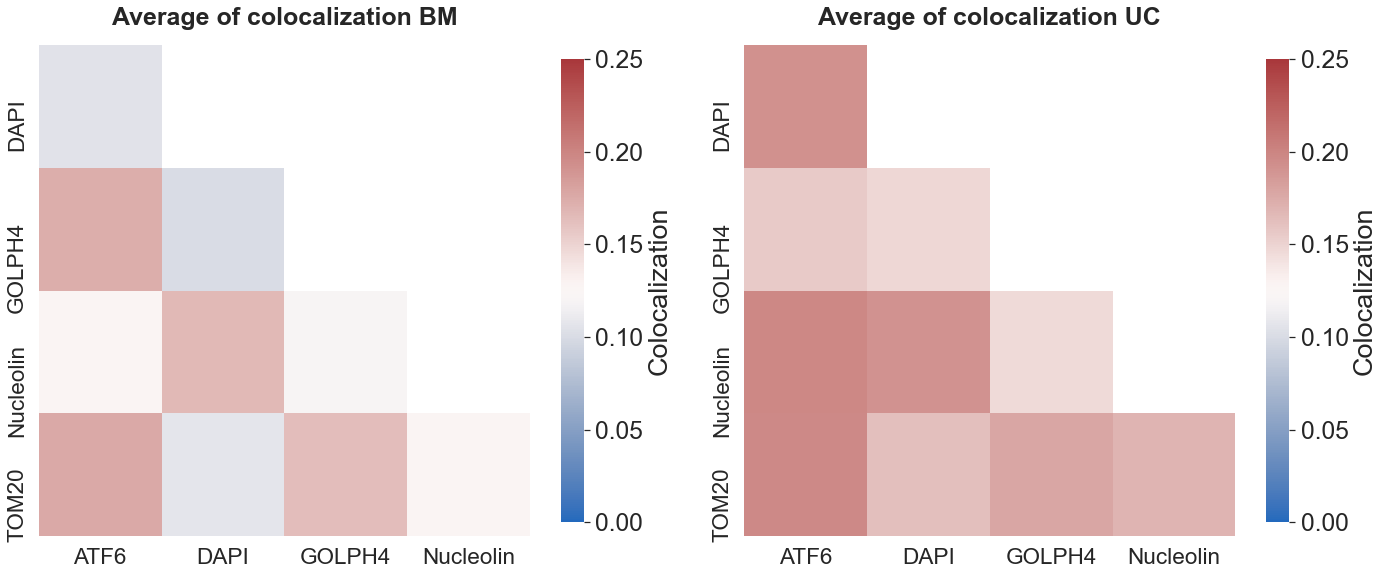

In [16]:
mask = np.zeros_like(coloc_matrix_UC[0])
mask[np.triu_indices_from(mask)] = True
annot = False
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.set(font_scale=2.25)

ax = axes[0]
ax.set_title(f"Average of colocalization BM",fontsize= 25, pad=20, fontweight ="bold")
df_mean = pd.DataFrame(coloc_matrix_BM.mean(axis=0)[1:,0:-1], columns=channel_names_modif[0:-1], index=channel_names_modif[1:])
g = sns.heatmap(df_mean, square=True, annot=annot, cmap="vlag", mask=mask[1:,0:-1], ax=ax, cbar_kws={"shrink": 0.7, 'label': 'Colocalization'}, vmin=0, vmax=0.25)
g.set_xticklabels(g.get_xmajorticklabels(),  rotation=0,fontsize = 22.5)
g.set_yticklabels(g.get_ymajorticklabels(), rotation=90,  fontsize = 22.5)

ax = axes[1]
ax.set_title(f"Average of colocalization UC",fontsize= 25, pad=20, fontweight ="bold")
df_mean = pd.DataFrame(coloc_matrix_UC.mean(axis=0)[1:,0:-1], columns=channel_names_modif[0:-1], index=channel_names_modif[1:])
g = sns.heatmap(df_mean, square=True, annot=annot, cmap="vlag", mask=mask[1:,0:-1], ax=ax, cbar_kws={"shrink": 0.7, 'label': 'Colocalization'}, vmin=0, vmax=0.25) 
g.set_xticklabels(g.get_xmajorticklabels(),  rotation=0, fontsize = 22.5)
g.set_yticklabels(g.get_ymajorticklabels(), rotation=90,fontsize = 22.5)
  
plt.tight_layout()
image_path_png = save_path + "/coloc_average_BM_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

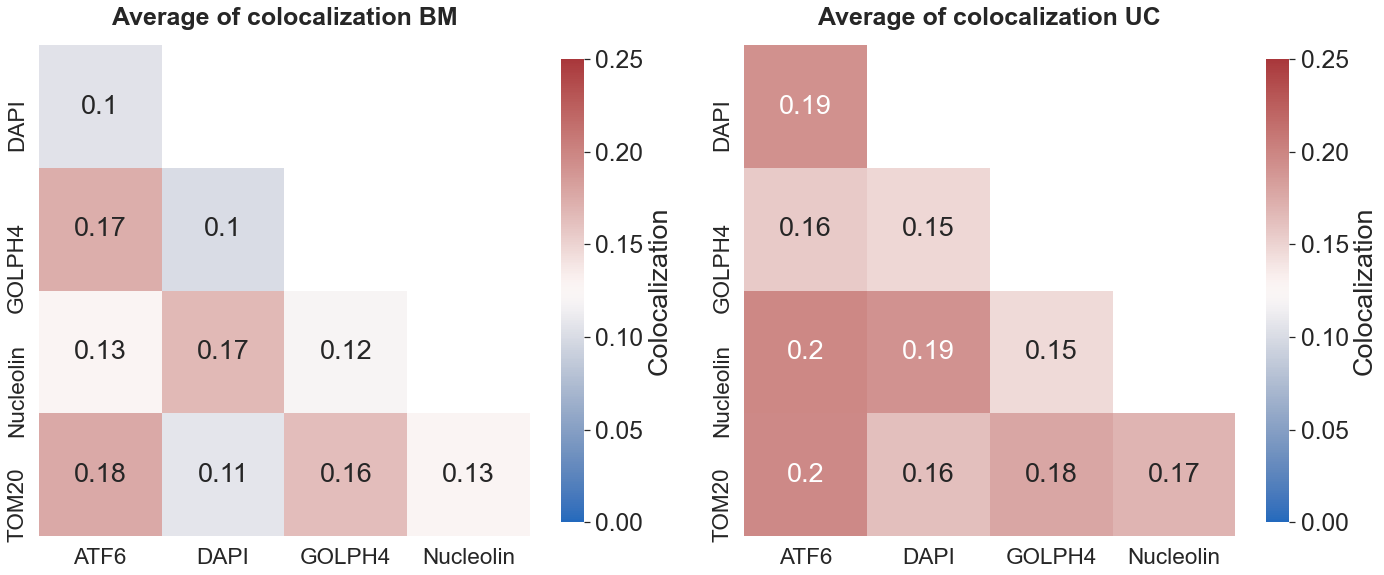

In [17]:
mask = np.zeros_like(coloc_matrix_UC[0])
mask[np.triu_indices_from(mask)] = True
annot = True
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.set(font_scale=2.25)

ax = axes[0]
ax.set_title(f"Average of colocalization BM",fontsize= 25, pad=20, fontweight ="bold")
df_mean = pd.DataFrame(coloc_matrix_BM.mean(axis=0)[1:,0:-1], columns=channel_names_modif[0:-1], index=channel_names_modif[1:])
g = sns.heatmap(df_mean, square=True, annot=annot, cmap="vlag", mask=mask[1:,0:-1], ax=ax, cbar_kws={"shrink": 0.7, 'label': 'Colocalization'}, vmin=0, vmax=0.25)
g.set_xticklabels(g.get_xmajorticklabels(),  rotation=0,fontsize = 22.5)
g.set_yticklabels(g.get_ymajorticklabels(), rotation=90,  fontsize = 22.5)

ax = axes[1]
ax.set_title(f"Average of colocalization UC",fontsize= 25, pad=20, fontweight ="bold")
df_mean = pd.DataFrame(coloc_matrix_UC.mean(axis=0)[1:,0:-1], columns=channel_names_modif[0:-1], index=channel_names_modif[1:])
g = sns.heatmap(df_mean, square=True, annot=annot, cmap="vlag", mask=mask[1:,0:-1], ax=ax, cbar_kws={"shrink": 0.7, 'label': 'Colocalization'}, vmin=0, vmax=0.25) 
g.set_xticklabels(g.get_xmajorticklabels(),  rotation=0, fontsize = 22.5)
g.set_yticklabels(g.get_ymajorticklabels(), rotation=90,fontsize = 22.5)
  
plt.tight_layout()
image_path_png = save_path + "/coloc_average_BM_UC_annot.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

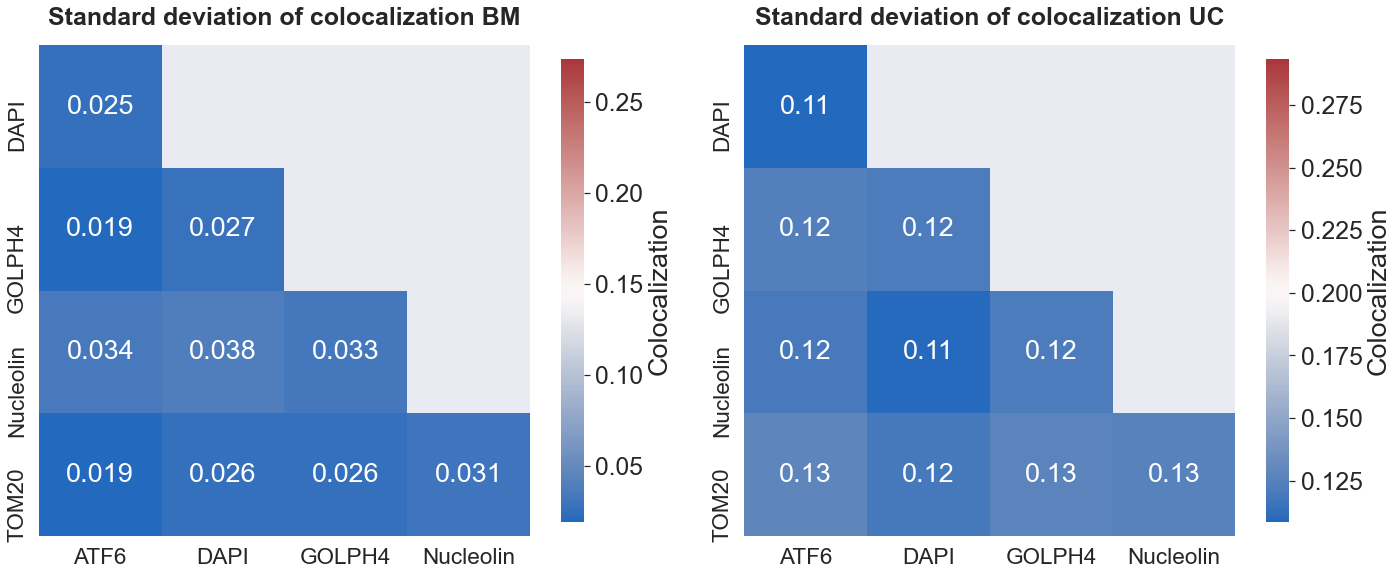

In [18]:
mask = np.zeros_like(coloc_matrix_UC[0])
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
ax.set_title(f"Standard deviation of colocalization BM",fontsize= 25, pad=20, fontweight ="bold")
df_mean = pd.DataFrame(coloc_matrix_BM.std(axis=0)[1:,0:-1], columns=channel_names_modif[0:-1], index=channel_names_modif[1:])
g = sns.heatmap(df_mean, square=True, annot=True, cmap="vlag", ax=ax, mask=mask[1:,0:-1], vmax=coloc_matrix_BM.mean(axis=0).max(), cbar_kws={"shrink": 0.7, 'label': 'Colocalization'})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22.5, rotation=0)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22.5, rotation=90)

ax = axes[1]
ax.set_title(f"Standard deviation of colocalization UC",fontsize= 25, pad=20, fontweight ="bold")
df_mean = pd.DataFrame(coloc_matrix_UC.std(axis=0)[1:,0:-1], columns=channel_names_modif[0:-1], index=channel_names_modif[1:])
g = sns.heatmap(df_mean, square=True, annot=True, cmap="vlag", ax=ax, mask=mask[1:,0:-1], vmax=coloc_matrix_UC.mean(axis=0).max(), cbar_kws={"shrink": 0.7, 'label': 'Colocalization'}) 
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 22.5, rotation=0)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 22.5, rotation=90)
  
plt.tight_layout()
image_path_png = save_path + "/coloc_std_BM_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

In [19]:
df_coloc_all = pd.concat([df_coloc_all_BM, df_coloc_all_UC])
df_coloc_all['Marker pair'] = df_coloc_all['Marker1'] + '_' + df_coloc_all['Marker2']

In [20]:
list_pair_modif = []

for i in range(len(channel_names_modif)):
    for j in range(i):
        list_pair_modif.append(f"{channel_names_modif[i]}_{channel_names_modif[j]}")
        
print(list_pair_modif)

['DAPI_ATF6', 'GOLPH4_ATF6', 'GOLPH4_DAPI', 'Nucleolin_ATF6', 'Nucleolin_DAPI', 'Nucleolin_GOLPH4', 'TOM20_ATF6', 'TOM20_DAPI', 'TOM20_GOLPH4', 'TOM20_Nucleolin']


In [21]:
df_coloc_all_temp = df_coloc_all[df_coloc_all['Marker pair'].isin(list_pair_modif)]
df_coloc_all_temp

,Coloc,Cell,Marker1,Marker2,Cell Type,Area,Cell number,Marker pair
0,0.095025,2,DAPI,ATF6,BM,101110.0,1,DAPI_ATF6
0,0.171378,2,GOLPH4,ATF6,BM,101110.0,1,GOLPH4_ATF6
0,0.087746,2,GOLPH4,DAPI,BM,101110.0,1,GOLPH4_DAPI
0,0.093908,2,Nucleolin,ATF6,BM,101110.0,1,Nucleolin_ATF6
0,0.143369,2,Nucleolin,DAPI,BM,101110.0,1,Nucleolin_DAPI
...,...,...,...,...,...,...,...,...
0,0.057044,30,Nucleolin,GOLPH4,UC,602817.0,14,Nucleolin_GOLPH4
0,0.132418,30,TOM20,ATF6,UC,602817.0,14,TOM20_ATF6
0,0.082571,30,TOM20,DAPI,UC,602817.0,14,TOM20_DAPI
0,0.093557,30,TOM20,GOLPH4,UC,602817.0,14,TOM20_GOLPH4


  0%|          | 0/1 [00:00<?, ?it/s]

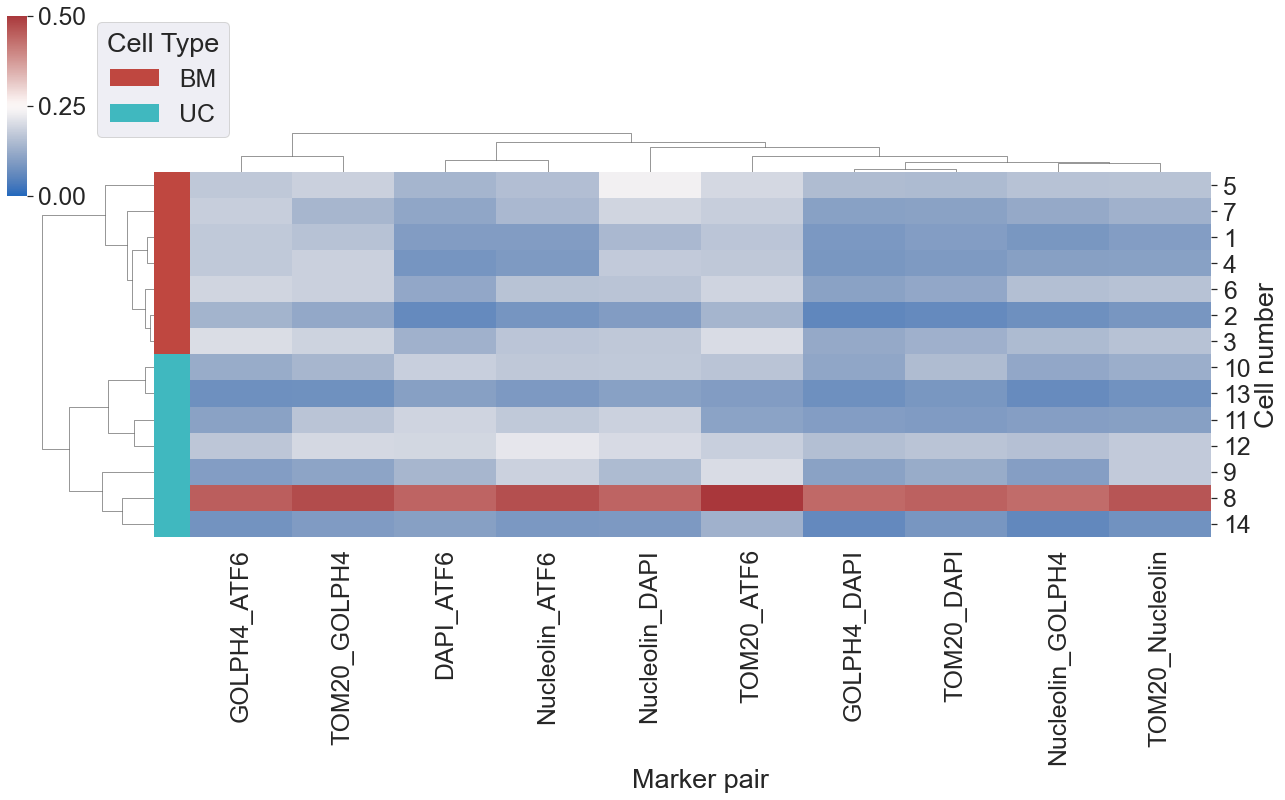

Wall time: 797 ms


In [22]:
%%time

metric_list = [
    'correlation',
]

data = df_coloc_all_temp
x = 'Marker pair'
y = 'Cell number'
values = 'Coloc'

data_pivot = data.pivot(index=y, columns=x, values=values)
data_pivot = data_pivot.loc[:, list_pair_modif]

lut1 = dict(zip(['BM', 'UC'], sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    sns.set(font_scale = 2.25)
    g=sns.clustermap(data_pivot, 
                     figsize=(18, 10),
                     vmin=0,
                     vmax=0.5,
                     row_colors=[row_colors1], 
                     yticklabels=True, 
                     cbar_pos=(0, 0.87, 0.015, .25), 
                     cbar_kws={"ticks":[0,0.25,0.5]},
                     metric=metric_temp,
                     dendrogram_ratio=(0.1, 0.1),
                    cmap='vlag') #       

    for label in np.unique(np.array(cell_type_label, dtype=object)):
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper right", bbox_to_anchor=(0.05, 4))
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

    image_path_png = save_path + "/pairwise_coloc_clustered_"+str(metric_temp)+".png"
    g.savefig(image_path_png, bbox_inches="tight")
    plt.show()